In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_percentage_error, classification_report, accuracy_score
import math 
from sklearn.linear_model import Ridge, LogisticRegression

In [2]:
from pandas import DataFrame

def data_normalization(df: DataFrame, days_range: int=24, include_cur_row: bool=False):
    '''
    Return the normalized data:
    + df: the dataframe to be normalized
    + range: the number of previous rows (or including the current row) to be considered in the normalization
    + include_cur_row: True if we consider the current row in the normalization process (calculate mean and std
    using the current row and (range-1) previous rows), False if we want to use all the passed data for normalization 
    processing ((calculate mean and std using (range) previous rows))
    '''
    
    df_roll = None

    if include_cur_row == False:
        df_roll = df.rolling(days_range, closed='left')
    else:
        df_roll = df.rolling(days_range)
        
    res_df = (df - df_roll.mean()) / df_roll.std()
    res_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return res_df[days_range:] #

In [3]:
# df = pd.read_csv('../ML_project/test_feats.csv')
# df_close = pd.read_csv('../ML_project/close_feature.csv')
# df_volume = pd.read_csv('../ML_project/volume_feature.csv')
# df = df.merge(df_close, how='left', on='time_open')
# df = df.merge(df_volume, how='left', on='time_open')

ori_df = pd.read_csv("../../data/test.csv")
df = pd.read_csv("../../data/norm2_features_test.csv")

In [25]:
ori_df["label"] = pd.DataFrame(np.vectorize(int)(ori_df["close_SMA8"] >= ori_df["close"].shift(15))).shift(-15)

In [26]:
ori_df[["close", "close_SMA8", "label"]][15:30].reset_index(drop=True)

,close,close_SMA8,label
0,13940.99,13602.68875,0.0
1,13820.50,13698.93875,0.0
2,13716.36,13761.65000,0.0
3,13529.01,13822.83625,0.0
4,13203.06,13785.08375,1.0
5,13330.18,13713.45625,0.0
6,13410.03,13661.61375,0.0
7,13601.01,13618.10000,0.0
8,13558.99,13573.50625,0.0
9,13780.41,13524.63125,0.0


In [27]:
ori_df.shape, df.shape

((39095, 650), (38899, 1049))

In [28]:
df["label"] = ori_df["label"][-df.shape[0]:]
# df = df.dropna()

In [29]:
df["label"].value_counts()

1.0    20016
0.0    18785
Name: label, dtype: int64

In [31]:
# del df['Unnamed: 0_x'], df['Unnamed: 0_y']
# df.drop(columns=["Unnamed: 0"], inplace=True)

In [32]:
cols = df.columns.tolist()

In [33]:
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,CoppockCurve,...,close_MeanDev48_over_StdDev48,open_MeanDev72_over_StdDev72,high_MeanDev72_over_StdDev72,low_MeanDev72_over_StdDev72,close_MeanDev72_over_StdDev72,open_MeanDev96_over_StdDev96,high_MeanDev96_over_StdDev96,low_MeanDev96_over_StdDev96,close_MeanDev96_over_StdDev96,label
98,-4.041061,-3.120724,-2.921683,-1.896961,-0.275110,-0.282832,-0.435369,-0.118386,-0.125574,-0.401595,...,0.691777,-0.607516,0.078228,-0.675151,-0.607516,-1.605684,-1.539372,-1.390583,-1.605684,NaN
99,-1.880514,-1.856152,-1.263240,-1.251338,-0.382461,-0.355814,-0.455111,-0.269429,-0.243482,-0.446999,...,0.833739,-0.587804,0.052260,-0.578136,-0.587804,-1.450141,-1.408524,-1.274043,-1.450141,NaN
100,-1.210826,-1.616976,-1.021304,-1.276152,-0.202239,-0.201541,-0.391993,-0.225061,-0.224300,-0.449975,...,1.316480,-0.405584,0.082917,-0.479569,-0.405584,-1.357146,-1.300793,-1.154903,-1.357146,NaN
101,-1.267400,-1.571846,-2.621830,-2.854008,0.608036,0.570923,0.940356,0.215504,0.180194,-0.468660,...,1.793157,-0.338824,0.165005,-0.972940,-0.338824,-1.229506,-1.173552,-1.059658,-1.229506,NaN
102,-2.727307,-3.404420,-4.740872,-4.650378,0.578523,0.523913,0.475274,0.632629,0.576126,-0.559112,...,1.174208,-0.642284,-0.308234,-3.025287,-0.642284,-1.120676,-1.072865,-1.469156,-1.120676,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38992,-0.045823,-0.454080,-0.258396,-0.336336,0.485025,0.480735,0.192932,0.509538,0.505191,0.076567,...,0.560197,-1.786816,-1.670174,-2.006602,-1.786816,-1.209686,-0.536116,-1.426774,-1.209686,0.0
38993,-0.336311,-0.717675,-0.913890,-0.936896,-0.119523,-0.125313,0.004775,-0.229877,-0.235537,0.020398,...,1.020184,-1.772073,-1.760782,-2.024509,-1.772073,-0.916821,-0.159748,-1.256788,-0.916821,0.0
38994,-0.936917,-1.389064,-1.366570,-1.406971,0.473302,0.467518,0.332347,0.428280,0.422684,-0.043409,...,0.930329,-1.835843,-1.902180,-2.074397,-1.835843,-0.701006,-0.158556,-1.160946,-0.701006,0.0
38995,-1.406968,-1.455565,-1.480861,-1.918626,-0.248721,-0.249349,-0.102518,-0.225371,-0.226077,-0.130512,...,0.528578,-1.945039,-2.026752,-2.069629,-1.945039,-0.629395,0.014639,-1.060909,-0.629395,0.0


In [34]:
feat = df.columns.tolist()[10:-1]

In [35]:
feat

['KAMA',
 'KST_kst',
 'KST_signal',
 'MACD_macd',
 'MACD_signal',
 'MassIndex',
 'OBV',
 'KVO',
 'VWAP',
 'AccuDist',
 'BOP',
 'UO',
 'TSI',
 'AO',
 'CCI4',
 'CHOP4',
 'SOBV4',
 'ATR4',
 'ForceIndex4',
 'ADX_plus_di',
 'ADX_minus_di',
 'ADX_adx',
 'open_SMA4',
 'open_SMMA4',
 'open_WMA4',
 'open_ALMA4',
 'open_TEMA4',
 'open_EMA4',
 'open_DEMA4',
 'open_DPO4',
 'open_HMA4',
 'open_MeanDev4',
 'open_StdDev4',
 'open_RSI4',
 'open_ROC4',
 'open_TRIX4',
 'close_SMA4',
 'close_SMMA4',
 'close_WMA4',
 'close_ALMA4',
 'close_TEMA4',
 'close_EMA4',
 'close_DEMA4',
 'close_DPO4',
 'close_HMA4',
 'close_MeanDev4',
 'close_StdDev4',
 'close_RSI4',
 'close_ROC4',
 'close_TRIX4',
 'high_SMA4',
 'high_SMMA4',
 'high_WMA4',
 'high_ALMA4',
 'high_TEMA4',
 'high_EMA4',
 'high_DEMA4',
 'high_DPO4',
 'high_HMA4',
 'high_MeanDev4',
 'high_StdDev4',
 'high_RSI4',
 'high_ROC4',
 'high_TRIX4',
 'low_SMA4',
 'low_SMMA4',
 'low_WMA4',
 'low_ALMA4',
 'low_TEMA4',
 'low_EMA4',
 'low_DEMA4',
 'low_DPO4',
 'low_H

In [36]:
# for f in feat:
#     if 'VTX' in f:
#         feat.remove(f)
#         continue
#     df[f] = data_normalization(df[[f]], days_range=100)

In [37]:
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,CoppockCurve,...,close_MeanDev48_over_StdDev48,open_MeanDev72_over_StdDev72,high_MeanDev72_over_StdDev72,low_MeanDev72_over_StdDev72,close_MeanDev72_over_StdDev72,open_MeanDev96_over_StdDev96,high_MeanDev96_over_StdDev96,low_MeanDev96_over_StdDev96,close_MeanDev96_over_StdDev96,label
98,-4.041061,-3.120724,-2.921683,-1.896961,-0.275110,-0.282832,-0.435369,-0.118386,-0.125574,-0.401595,...,0.691777,-0.607516,0.078228,-0.675151,-0.607516,-1.605684,-1.539372,-1.390583,-1.605684,NaN
99,-1.880514,-1.856152,-1.263240,-1.251338,-0.382461,-0.355814,-0.455111,-0.269429,-0.243482,-0.446999,...,0.833739,-0.587804,0.052260,-0.578136,-0.587804,-1.450141,-1.408524,-1.274043,-1.450141,NaN
100,-1.210826,-1.616976,-1.021304,-1.276152,-0.202239,-0.201541,-0.391993,-0.225061,-0.224300,-0.449975,...,1.316480,-0.405584,0.082917,-0.479569,-0.405584,-1.357146,-1.300793,-1.154903,-1.357146,NaN
101,-1.267400,-1.571846,-2.621830,-2.854008,0.608036,0.570923,0.940356,0.215504,0.180194,-0.468660,...,1.793157,-0.338824,0.165005,-0.972940,-0.338824,-1.229506,-1.173552,-1.059658,-1.229506,NaN
102,-2.727307,-3.404420,-4.740872,-4.650378,0.578523,0.523913,0.475274,0.632629,0.576126,-0.559112,...,1.174208,-0.642284,-0.308234,-3.025287,-0.642284,-1.120676,-1.072865,-1.469156,-1.120676,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38992,-0.045823,-0.454080,-0.258396,-0.336336,0.485025,0.480735,0.192932,0.509538,0.505191,0.076567,...,0.560197,-1.786816,-1.670174,-2.006602,-1.786816,-1.209686,-0.536116,-1.426774,-1.209686,0.0
38993,-0.336311,-0.717675,-0.913890,-0.936896,-0.119523,-0.125313,0.004775,-0.229877,-0.235537,0.020398,...,1.020184,-1.772073,-1.760782,-2.024509,-1.772073,-0.916821,-0.159748,-1.256788,-0.916821,0.0
38994,-0.936917,-1.389064,-1.366570,-1.406971,0.473302,0.467518,0.332347,0.428280,0.422684,-0.043409,...,0.930329,-1.835843,-1.902180,-2.074397,-1.835843,-0.701006,-0.158556,-1.160946,-0.701006,0.0
38995,-1.406968,-1.455565,-1.480861,-1.918626,-0.248721,-0.249349,-0.102518,-0.225371,-0.226077,-0.130512,...,0.528578,-1.945039,-2.026752,-2.069629,-1.945039,-0.629395,0.014639,-1.060909,-0.629395,0.0


In [38]:
df.dropna(inplace=True)

In [39]:
X, y = df[feat].iloc[:], df['label'][:]
X_train, X_valid, X_test = X[:int(X.shape[0]*0.7)], X[int(X.shape[0]*0.7):int(X.shape[0]*0.85)], X[int(X.shape[0]*0.85):]
y_train, y_valid, y_test = y[:int(X.shape[0]*0.7)], y[int(X.shape[0]*0.7):int(X.shape[0]*0.85)], y[int(X.shape[0]*0.85):]

In [40]:
params = {'objective': 'binary',
                      'metric': ['auc'],
                      'boosting':'gbdt',
                      'num_boost_round':1000,
                      'early_stopping_rounds':50,
                      'learning_rate': 0.01,
                      'max_depth': 1,
                      'num_leaves': 2,
                      'is_unbalance': True,
                      'feature_fraction': 0.8,
#                       'bagging_fraction': 0.8,
#                       'min_data_in_leaf': 10,
                      'verbosity': 1}

In [41]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference=train_data)

In [42]:
model = lgb.train(params, train_data,                     
                  valid_sets=[train_data, valid_data],
                  valid_names=['train', 'valid'])

/home/hoangvictor/Installations/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 14252, number of negative: 12908
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264690
[LightGBM] [Info] Number of data points in the train set: 27160, number of used features: 1038
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524742 -> initscore=0.099050
[LightGBM] [Info] Start training from score 0.099050
[1]	train's auc: 0.623212	valid's auc: 0.597745
Training until validation scores don't improve for 50 rounds
[2]	train's auc: 0.623212	valid's auc: 0.597745
[3]	train's auc: 0.623212	valid's auc: 0.597745
[4]	train's auc: 0.624729	valid's auc: 0.5981
[5]	train's auc: 0.624729	valid's auc: 0.5981
[6]	train's auc: 0.628494	valid's auc: 0.60053
[7]	train's auc: 0.628494	valid's auc: 0.60053
[8]	train's auc: 0.628496	valid's auc: 0.600497
[9]	train's auc: 0.628496	valid's auc: 0.600497
[10]	train's a

[178]	train's auc: 0.699313	valid's auc: 0.662099
[179]	train's auc: 0.700589	valid's auc: 0.662951
[180]	train's auc: 0.700542	valid's auc: 0.662888
[181]	train's auc: 0.700774	valid's auc: 0.663092
[182]	train's auc: 0.700773	valid's auc: 0.663108
[183]	train's auc: 0.701002	valid's auc: 0.663472
[184]	train's auc: 0.701266	valid's auc: 0.664033
[185]	train's auc: 0.701293	valid's auc: 0.66397
[186]	train's auc: 0.701293	valid's auc: 0.663948
[187]	train's auc: 0.701508	valid's auc: 0.664179
[188]	train's auc: 0.701936	valid's auc: 0.66458
[189]	train's auc: 0.70253	valid's auc: 0.664854
[190]	train's auc: 0.702525	valid's auc: 0.66478
[191]	train's auc: 0.702787	valid's auc: 0.664886
[192]	train's auc: 0.702568	valid's auc: 0.664697
[193]	train's auc: 0.703073	valid's auc: 0.665232
[194]	train's auc: 0.703055	valid's auc: 0.665258
[195]	train's auc: 0.703263	valid's auc: 0.665853
[196]	train's auc: 0.703256	valid's auc: 0.665845
[197]	train's auc: 0.70344	valid's auc: 0.66599
[198]	

[360]	train's auc: 0.72484	valid's auc: 0.686401
[361]	train's auc: 0.725025	valid's auc: 0.686603
[362]	train's auc: 0.725418	valid's auc: 0.687288
[363]	train's auc: 0.725625	valid's auc: 0.687874
[364]	train's auc: 0.72532	valid's auc: 0.687377
[365]	train's auc: 0.725693	valid's auc: 0.687936
[366]	train's auc: 0.72542	valid's auc: 0.687516
[367]	train's auc: 0.725937	valid's auc: 0.688051
[368]	train's auc: 0.725735	valid's auc: 0.687684
[369]	train's auc: 0.726398	valid's auc: 0.688332
[370]	train's auc: 0.726411	valid's auc: 0.688462
[371]	train's auc: 0.726535	valid's auc: 0.68865
[372]	train's auc: 0.726456	valid's auc: 0.688571
[373]	train's auc: 0.727691	valid's auc: 0.689788
[374]	train's auc: 0.727663	valid's auc: 0.689792
[375]	train's auc: 0.727929	valid's auc: 0.689995
[376]	train's auc: 0.727773	valid's auc: 0.689904
[377]	train's auc: 0.72792	valid's auc: 0.689969
[378]	train's auc: 0.7279	valid's auc: 0.690059
[379]	train's auc: 0.728182	valid's auc: 0.690404
[380]	t

[536]	train's auc: 0.74071	valid's auc: 0.703241
[537]	train's auc: 0.740732	valid's auc: 0.70333
[538]	train's auc: 0.740933	valid's auc: 0.703455
[539]	train's auc: 0.740793	valid's auc: 0.703456
[540]	train's auc: 0.740986	valid's auc: 0.703538
[541]	train's auc: 0.740892	valid's auc: 0.703414
[542]	train's auc: 0.741034	valid's auc: 0.703749
[543]	train's auc: 0.740932	valid's auc: 0.703644
[544]	train's auc: 0.741235	valid's auc: 0.70397
[545]	train's auc: 0.741215	valid's auc: 0.703874
[546]	train's auc: 0.741504	valid's auc: 0.704222
[547]	train's auc: 0.741277	valid's auc: 0.703979
[548]	train's auc: 0.741584	valid's auc: 0.70419
[549]	train's auc: 0.741519	valid's auc: 0.704121
[550]	train's auc: 0.74182	valid's auc: 0.704396
[551]	train's auc: 0.741748	valid's auc: 0.704284
[552]	train's auc: 0.741585	valid's auc: 0.704136
[553]	train's auc: 0.741865	valid's auc: 0.704148
[554]	train's auc: 0.741766	valid's auc: 0.704255
[555]	train's auc: 0.741954	valid's auc: 0.704246
[556]

[748]	train's auc: 0.752528	valid's auc: 0.716692
[749]	train's auc: 0.752674	valid's auc: 0.71681
[750]	train's auc: 0.752616	valid's auc: 0.716729
[751]	train's auc: 0.752681	valid's auc: 0.716861
[752]	train's auc: 0.752717	valid's auc: 0.716879
[753]	train's auc: 0.752924	valid's auc: 0.717093
[754]	train's auc: 0.752967	valid's auc: 0.717169
[755]	train's auc: 0.75326	valid's auc: 0.717329
[756]	train's auc: 0.753168	valid's auc: 0.717263
[757]	train's auc: 0.753327	valid's auc: 0.717385
[758]	train's auc: 0.75324	valid's auc: 0.717308
[759]	train's auc: 0.753414	valid's auc: 0.717445
[760]	train's auc: 0.75336	valid's auc: 0.717744
[761]	train's auc: 0.753404	valid's auc: 0.717734
[762]	train's auc: 0.753645	valid's auc: 0.71783
[763]	train's auc: 0.753595	valid's auc: 0.717791
[764]	train's auc: 0.753686	valid's auc: 0.717904
[765]	train's auc: 0.753612	valid's auc: 0.717775
[766]	train's auc: 0.754008	valid's auc: 0.718012
[767]	train's auc: 0.753972	valid's auc: 0.71797
[768]	

[927]	train's auc: 0.762393	valid's auc: 0.726227
[928]	train's auc: 0.762293	valid's auc: 0.726202
[929]	train's auc: 0.762416	valid's auc: 0.726382
[930]	train's auc: 0.762332	valid's auc: 0.72629
[931]	train's auc: 0.762535	valid's auc: 0.726411
[932]	train's auc: 0.762488	valid's auc: 0.726402
[933]	train's auc: 0.762469	valid's auc: 0.726415
[934]	train's auc: 0.762605	valid's auc: 0.726576
[935]	train's auc: 0.762716	valid's auc: 0.726671
[936]	train's auc: 0.762667	valid's auc: 0.726634
[937]	train's auc: 0.762796	valid's auc: 0.72674
[938]	train's auc: 0.762744	valid's auc: 0.726748
[939]	train's auc: 0.762871	valid's auc: 0.726825
[940]	train's auc: 0.762861	valid's auc: 0.726825
[941]	train's auc: 0.762806	valid's auc: 0.726809
[942]	train's auc: 0.762932	valid's auc: 0.726901
[943]	train's auc: 0.762914	valid's auc: 0.727078
[944]	train's auc: 0.763065	valid's auc: 0.727067
[945]	train's auc: 0.763016	valid's auc: 0.727065
[946]	train's auc: 0.763156	valid's auc: 0.727165
[9

In [43]:
pred = model.predict(X_test)
roc_auc_score(y_test, pred)

0.7546824496689141

In [26]:
pred

array([0.55828277, 0.55693643, 0.5423551 , ..., 0.42001686, 0.31681702,
       0.31681702])

In [20]:
for x in range(30, 70, 2):
    print(x)
    y_pred = (pred >= x/100) * 1
    print(accuracy_score(y_test, y_pred))

30
0.487829962290024
32
0.487829962290024
34
0.487829962290024
36
0.487829962290024
38
0.487829962290024
40
0.487829962290024
42
0.487829962290024
44
0.487829962290024
46
0.487829962290024
48
0.487829962290024
50
0.487829962290024
52
0.512170037709976
54
0.512170037709976
56
0.512170037709976
58
0.512170037709976
60
0.512170037709976
62
0.512170037709976
64
0.512170037709976
66
0.512170037709976
68
0.512170037709976


In [21]:
y_test.value_counts()

0.0    2988
1.0    2846
Name: label, dtype: int64

In [45]:
y_pred = (pred >= 0.52) * 1
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.64      0.83      0.73      3035
         1.0       0.73      0.50      0.59      2786

    accuracy                           0.67      5821
   macro avg       0.69      0.66      0.66      5821
weighted avg       0.69      0.67      0.66      5821



In [44]:
importance_df = (
    pd.DataFrame({
        'feature_name': model.feature_name(),
        'importance_gain': model.feature_importance(importance_type='gain'),
        'importance_split': model.feature_importance(importance_type='split'),
    })
    .sort_values('importance_gain', ascending=False)
    .reset_index(drop=True)
)
importance_df.head(50)

,feature_name,importance_gain,importance_split
0,open_ROC96,121042.371475,394
1,open_SMA72,46714.621017,181
2,close_ROC96,19317.541946,70
3,open_TRIX96,17207.169922,32
4,high_ROC72,9792.334007,63
5,open_SMA96,9741.571938,41
6,close_SMA72,8761.777939,31
7,low_TRIX96,5455.255020,14
8,open_ROC72,5407.505974,39
9,low_SMA72,5002.006027,35


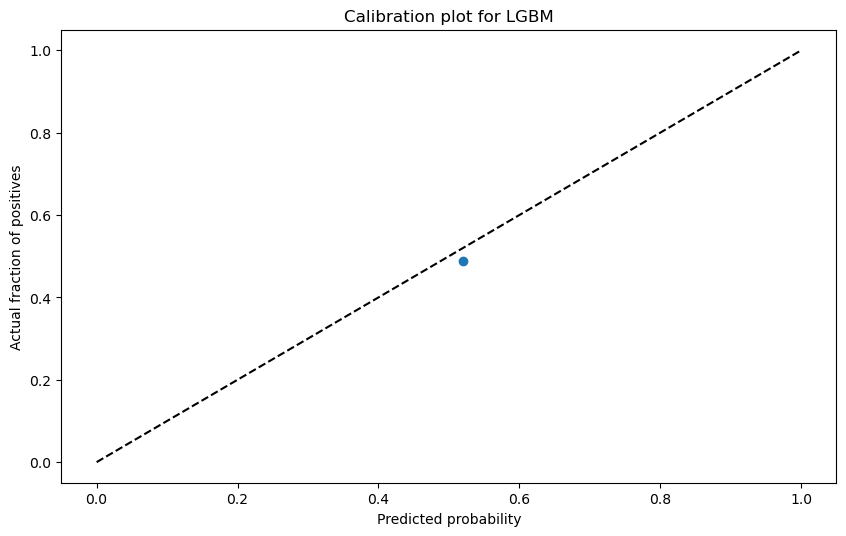

In [24]:
# creating a dataframe of target and probabilities
preds = model.predict(X_test)
prob_df_lgbm = pd.DataFrame({'y':y_test, 'y_hat': preds})

# binning the dataframe, so we can see success rates for bins of probability
bins = np.arange(0.05, 1.00, 0.05)
prob_df_lgbm.loc[:,'prob_bin'] = np.digitize(prob_df_lgbm['y_hat'], bins)
prob_df_lgbm.loc[:,'prob_bin_val'] = prob_df_lgbm['prob_bin'].replace(dict(zip(range(len(bins)), bins)))

# opening figure
plt.figure(figsize=(10,6), dpi=100)

# plotting ideal line
plt.plot([0,1],[0,1], 'k--', label='ideal')

# plotting calibration for lgbm
calibration_y = prob_df_lgbm.groupby('prob_bin_val')['y'].mean()
calibration_x = prob_df_lgbm.groupby('prob_bin_val')['y_hat'].mean()
plt.plot(calibration_x, calibration_y, marker='o', label='lgbm')

# legend and titles
plt.title('Calibration plot for LGBM')
plt.xlabel('Predicted probability')
plt.ylabel('Actual fraction of positives')
plt.show()

In [51]:
lr = LogisticRegression()

# then, we apply the model to the data in order to get the leave indexes
leaves = model.predict(pd.concat([X_train]), pred_leaf=True)

# then, we one-hot encode the leave indexes so we can use them in the logistic regression
encoder = preprocessing.OneHotEncoder()
leaves_encoded = encoder.fit_transform(leaves)

# and fit it to the encoded leaves
lr.fit(leaves_encoded, pd.concat([y_train]))

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [52]:
leaves = model.predict(X_test, pred_leaf=True)

# then, we one-hot encode the leave indexes so we can use them in the logistic regression
leaves_encoded = encoder.transform(leaves)
pred = lr.predict_proba(leaves_encoded)

In [65]:
roc_auc_score(y_test, pred[:, 1])

0.6601056290947988

In [53]:
for x in range(30, 70, 2):
    print(x)
    y_pred = (pred[:,1] >= x/100) * 1
    print(accuracy_score(y_test, y_pred))

30
0.622492713869364
32
0.6667238127893023
34
0.7032401851534373
36
0.7229555974627122
38
0.7572432710440596
40
0.7647865592319562
42
0.7745585462026402
44
0.7913595062575004
46
0.7977027258700498
48
0.8062746442653866
50
0.808674781416081
52
0.8088462197839876
54
0.8088462197839876
56
0.8100462883593348
58
0.8100462883593348
60
0.8100462883593348
62
0.8100462883593348
64
0.8100462883593348
66
0.8100462883593348
68
0.8100462883593348


In [60]:
y_pred = (pred[:,1] >= 0.38) * 1

In [61]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85      4725
         1.0       0.31      0.22      0.26      1108

    accuracy                           0.76      5833
   macro avg       0.57      0.55      0.56      5833
weighted avg       0.73      0.76      0.74      5833



In [5]:
df_resid.index = df_resid['time_open']

In [6]:
df = df_resid['volume']

<AxesSubplot:xlabel='time_open'>

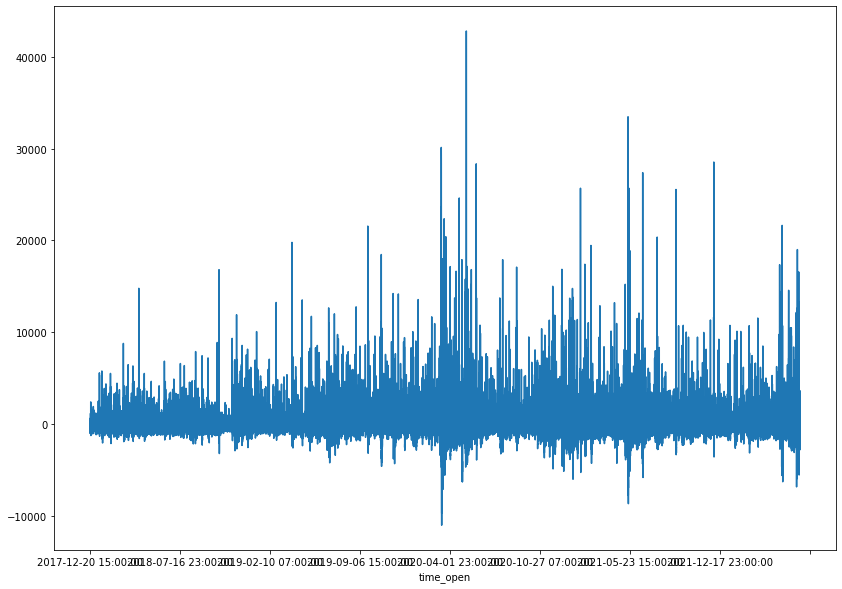

In [13]:
(df).plot(figsize=(14, 10))

In [50]:
df_diff = np.log(abs(df/df.shift(1))).dropna()

<AxesSubplot:>

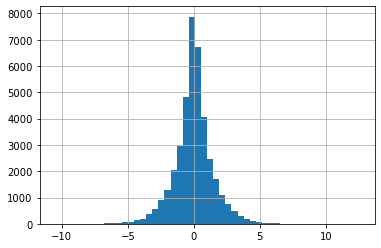

In [51]:
df_diff.hist(bins=50)

<AxesSubplot:>

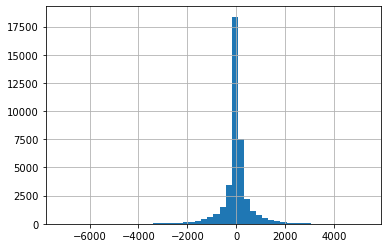

In [21]:
df_resid['close'].hist(bins=50)

In [22]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller((df/df.shift(1)).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -198.679722
p-value: 0.000000


<AxesSubplot:>

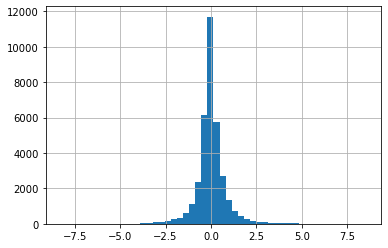

In [27]:
np.log(df_resid['close']/df_resid['close'].shift(1)).dropna().hist(bins=50)

In [28]:
df_trend = pd.read_csv('../ML_project/trend_seasonal.csv')

<AxesSubplot:>

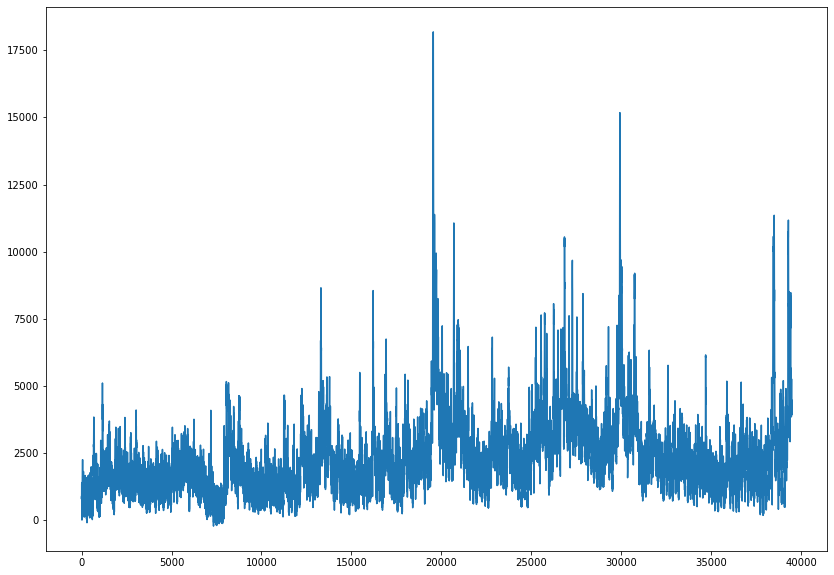

In [32]:
df_trend['volume'].plot(figsize=(14, 10))

In [33]:
result = adfuller(df_trend['volume'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -12.089281
p-value: 0.000000


<AxesSubplot:>

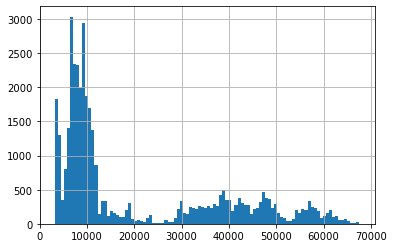

In [42]:
df_trend['close'].hist(bins=100)

<AxesSubplot:>

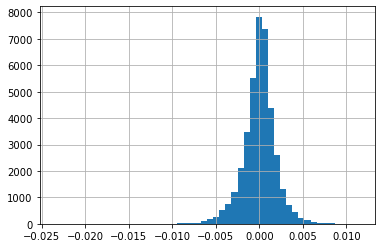

In [47]:
np.log(df_trend['close']/df_trend['close'].shift(1)).hist(bins=50)

In [53]:
df_feat = pd.read_csv('../ML_project/test_feats.csv')

In [55]:
df_feat.columns.tolist()

['Unnamed: 0',
 'time_open',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'quote_asset_volume',
 'number_of_trades',
 'taker_buy_base_asset_volume',
 'taker_buy_quote_asset_volume',
 'CoppockCurve',
 'KAMA',
 'KST_kst',
 'KST_signal',
 'MACD_macd',
 'MACD_signal',
 'MassIndex',
 'OBV',
 'KVO',
 'VWAP',
 'AccuDist',
 'BOP',
 'UO',
 'TSI',
 'AO',
 'CCI4',
 'CHOP4',
 'VTX4',
 'SOBV4',
 'ATR4',
 'ForceIndex4',
 'ADX_plus_di',
 'ADX_minus_di',
 'ADX_adx',
 'open_SMA4',
 'open_SMMA4',
 'open_WMA4',
 'open_ALMA4',
 'open_TEMA4',
 'open_EMA4',
 'open_DEMA4',
 'open_DPO4',
 'open_HMA4',
 'open_MeanDev4',
 'open_StdDev4',
 'open_RSI4',
 'open_ROC4',
 'open_TRIX4',
 'close_SMA4',
 'close_SMMA4',
 'close_WMA4',
 'close_ALMA4',
 'close_TEMA4',
 'close_EMA4',
 'close_DEMA4',
 'close_DPO4',
 'close_HMA4',
 'close_MeanDev4',
 'close_StdDev4',
 'close_RSI4',
 'close_ROC4',
 'close_TRIX4',
 'high_SMA4',
 'high_SMMA4',
 'high_WMA4',
 'high_ALMA4',
 'high_TEMA4',
 'high_EMA4',
 'high_DEMA4',
 'high_DPO

<AxesSubplot:>

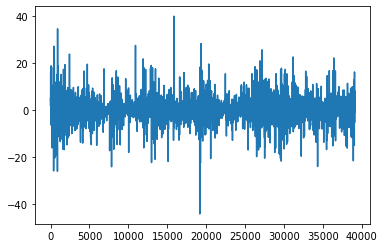

In [56]:
df_feat['CoppockCurve'].plot()

In [185]:
roc_auc_score(label, df_feat['CoppockCurve'][1000:-1])

0.4988342151224162

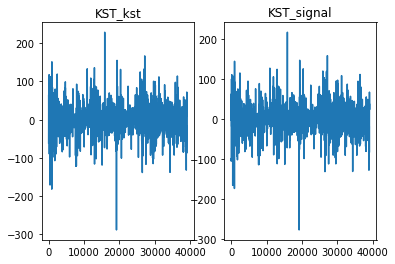

In [61]:
plt.subplot(121)
# df["KST_kst"] /= 100
plt.plot(df_feat["KST_kst"])
plt.title("KST_kst")
plt.subplot(122)
# df["KST_signal"] /= 100
plt.plot(df_feat["KST_signal"])
plt.title("KST_signal")
plt.show()

In [164]:
macd = data_normalization(df_feat[['MACD_macd']], days_range=1000)

<AxesSubplot:>

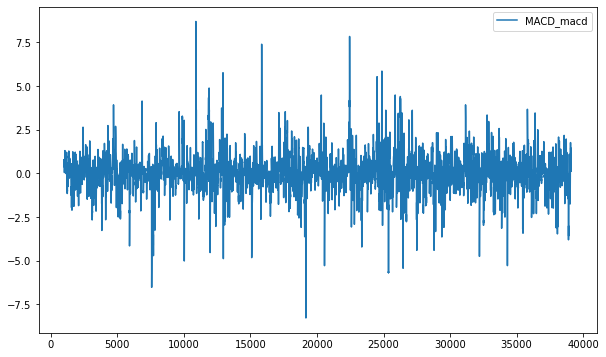

In [165]:
macd.plot(figsize=(10, 6))

In [186]:
roc_auc_score(label, macd[:-1])

0.49695709691488166

In [187]:
roc_auc_score(label, df_feat['MACD_macd'][1000:-1])

0.49610677232987554

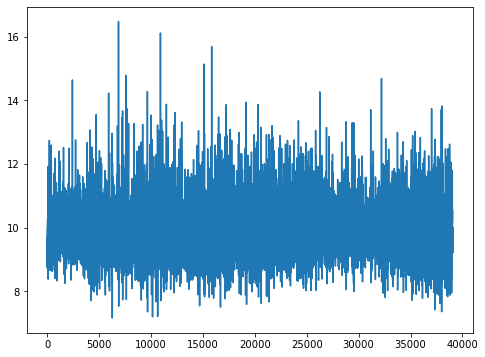

In [68]:
df_feat['MassIndex'].plot(figsize=(8, 6));

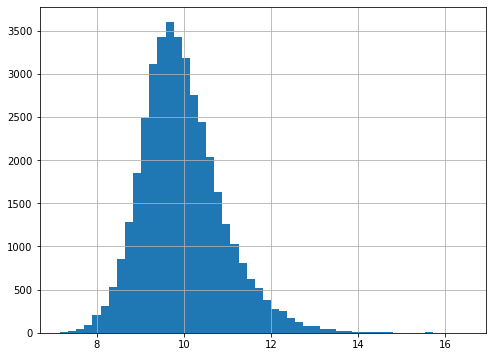

In [69]:
df_feat['MassIndex'].hist(figsize=(8, 6), bins=50);

<AxesSubplot:>

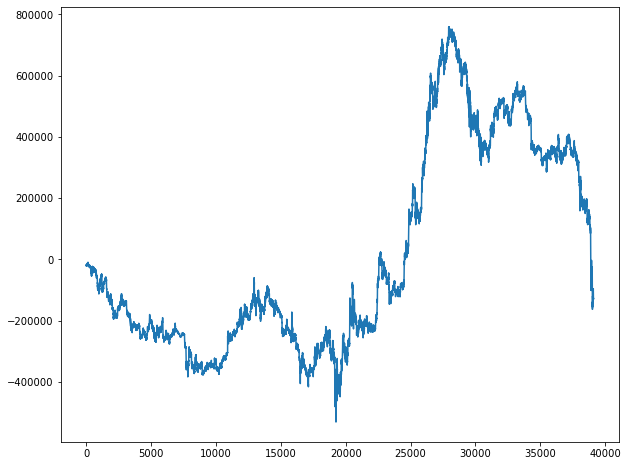

In [105]:
df_feat['OBV'].plot(figsize=(10,8))

<AxesSubplot:>

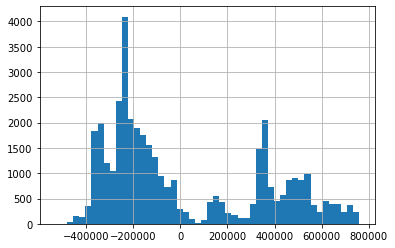

In [76]:
df_feat['OBV'].hist(bins=50)

In [180]:
obv = data_normalization(df_feat[['OBV']], days_range=500, include_cur_row=False)

<AxesSubplot:>

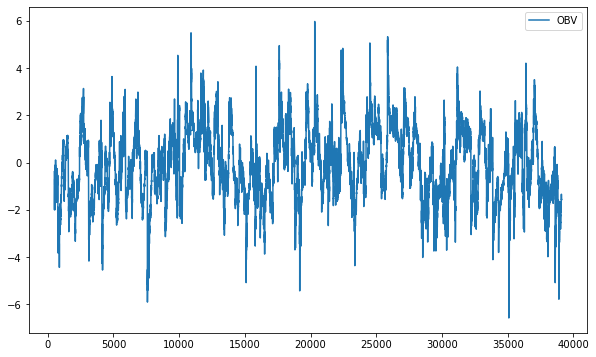

In [181]:
obv[:].plot(figsize=(10, 6))

In [182]:
roc_auc_score(label, df_feat['OBV'][1000:-1])

0.49366414386306345

In [184]:
roc_auc_score(label, obv[500:-1])

0.5015395341382862

In [159]:
obv.std()

OBV    1.485461
dtype: float64

<AxesSubplot:>

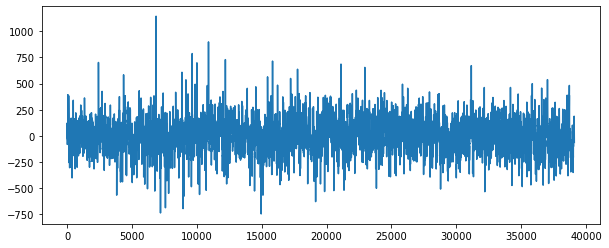

In [119]:
df_feat['CCI48'].plot(figsize=(10,4))

<AxesSubplot:>

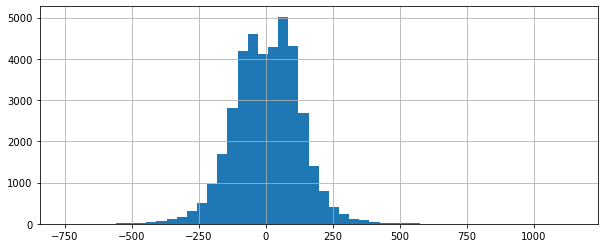

In [120]:
df_feat['CCI48'].hist(figsize=(10,4), bins=50)

<AxesSubplot:>

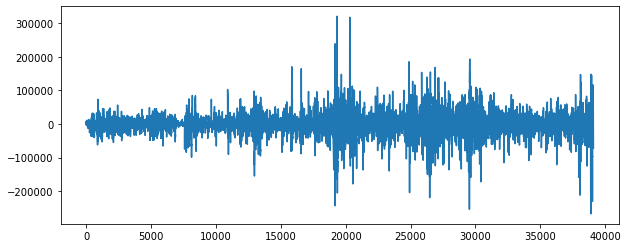

In [141]:
df_feat['KVO'].plot(figsize=(10, 4))

<AxesSubplot:>

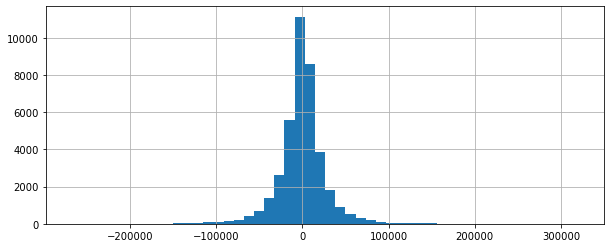

In [142]:
df_feat['KVO'].hist(figsize=(10, 4), bins=50)

In [152]:
kvo = data_normalization(df_feat[['KVO']], days_range=1000)

<AxesSubplot:>

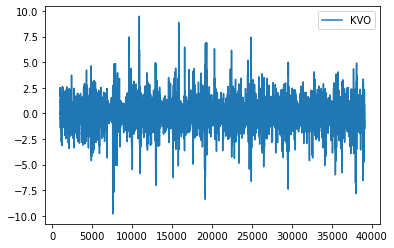

In [153]:
kvo.plot()

In [169]:
df_feat['label'] = ((df_feat['close'] - df_feat['close'].shift(1) >= 0) * 1).shift(-1)

In [171]:
label = df_feat['label'][1000:-1]

In [173]:
roc_auc_score(label, kvo[:-1])

0.47895009098792657

In [174]:
roc_auc_score(label, df_feat['KVO'][1000:-1])

0.47942117604183876

<AxesSubplot:>

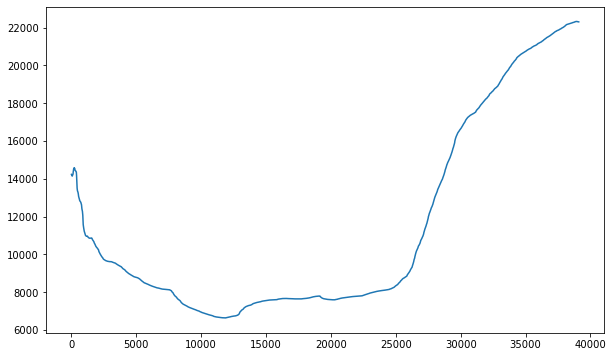

In [189]:
df_feat['VWAP'].plot(figsize=(10,6))

In [195]:
vwap = (df_feat['VWAP']/df_feat['VWAP'].shift(1))

In [190]:
roc_auc_score(label, df_feat['VWAP'][1000:-1])

0.49222744819732717

In [196]:
roc_auc_score(label, vwap[1000:-1])

0.4983598927116784